# Getting Meta with Big Data Malaysia
Scraping the Big Data Malaysia Facebook group for fun. Profit unlikely.

## Get all the data
This notebook assumes you have already prepared a flattened JSON file into `all_the_data.json`, which you would have done by:
* Writing your oauth token into `oauth_file` according to the instructions in `pull_feed.py`.
* Running `python pull_feed.py` to pull down the feed pages into the BigDataMyData directory.
* Running `python flatten_saved_data.py > all_the_data.json`.

In [181]:
# we need this for later:
%matplotlib inline

import json
INPUT_FILE = "all_the_data.json"
with open(INPUT_FILE, "r") as big_data_fd:
	big_data = json.load(big_data_fd)

## Is it big enough?
Now we have all our data loaded into variable `big_data`, but can we really say it's Big Data?

In [182]:
print "We have {} posts".format(len(big_data))

We have 1946 posts


Wow! So data! Very big!

Seriously though... it's not big. In fact it's rather small. How small is small? Here's a clue...

In [183]:
import os
print "The source file is {} bytes. Pathetic.".format(os.stat(INPUT_FILE).st_size)

The source file is 3773450 bytes. Pathetic.


At the time this was written, the file was just about 3MB, and there were less than 2k posts... note that excludes comments made on posts, but still, this stuff is small. It is small enough that at no point do we need to do anything terribly clever from a data indexing perspective, so in general everything below will take the simplistic but often appropriate approach of slicing and dicing our `big_data` object directly.

Anyway, size doesn't matter. It's *variety* that counts.

## Fields of gold

Now we know how many elements (rows I guess?) we have, but how much variety do we have in this data? One measure of this may be to look at the number of fields in each of those items:

In [184]:
import itertools
all_the_fields = set(itertools.chain.from_iterable(big_data))
print "We have {} different field names:".format(len(all_the_fields))
print all_the_fields

We have 30 different field names:
set([u'application', u'actions', u'likes', u'created_time', u'message', u'id', u'story', u'from', u'subscribed', u'privacy', u'comments', u'shares', u'to', u'story_tags', u'type', u'status_type', u'picture', u'description', u'object_id', u'link', u'properties', u'icon', u'name', u'message_tags', u'with_tags', u'updated_time', u'caption', u'place', u'source', u'is_hidden'])


Are we missing anything? A good way to sanity check things is to actually inspect the data, so let's look at a random item:

In [185]:
import random
import pprint
# re-run this as much as you like to inspect different items
pprint.pprint(random.choice(big_data))

{u'actions': [{u'link': u'https://www.facebook.com/497068793653308/posts/616526251707561',
               u'name': u'Comment'},
              {u'link': u'https://www.facebook.com/497068793653308/posts/616526251707561',
               u'name': u'Like'},
              {u'link': u'/groups/bigdatamy/', u'name': u'Create Group Chat'}],
 u'comments': [{u'data': [{u'can_remove': True,
                           u'created_time': u'2013-03-20T07:31:01+0000',
                           u'from': {u'id': u'10152075362431725',
                                     u'name': u'Tirath Ramdas'},
                           u'id': u'616548381705348',
                           u'like_count': 1,
                           u'message': u'"which bar do employees of X hang out at" sounds like the stuff commercially-sanctioned stalking is made of. It\'s such a moral gray area, but seems so tantalizingly powerful.',
                           u'user_likes': False},
                          {u'can_remove': True,

From that you should be able to sense that we are missing some things - it isn't simply that there are some number of fields that describe each item, because some of those fields have data hierarchies beneath them, for example:

In [45]:
pprint.pprint(big_data[234])

{u'actions': [{u'link': u'https://www.facebook.com/497068793653308/posts/1032324310127751',
               u'name': u'Comment'},
              {u'link': u'https://www.facebook.com/497068793653308/posts/1032324310127751',
               u'name': u'Like'},
              {u'link': u'/groups/bigdatamy/', u'name': u'Create Group Chat'}],
 u'comments': [{u'data': [{u'can_remove': True,
                           u'created_time': u'2015-02-02T14:20:46+0000',
                           u'from': {u'id': u'10203864949854090',
                                     u'name': u'Teuku Faruq'},
                           u'id': u'1033140356712813',
                           u'like_count': 1,
                           u'message': u'Interesting startup, all the best!',
                           u'user_likes': False},
                          {u'can_remove': True,
                           u'created_time': u'2015-02-04T07:45:13+0000',
                           u'from': {u'id': u'10203477707997024',


From that we can see some fields have hierarchies within them, e.g. likes have a list of id dictionaries, which happen to be relatively trivial (names and ids... I wonder why Facebook didn't just post the id and make you look up the name?) but the comment field is a bit more complex, wherein it contains a list of dictionaries with each field potentially being a dictionary of its own, e.g. we can see that the second comment on that post tagged Teuku Faruq:

In [186]:
pprint.pprint(big_data[234]['comments'][0]['data'][1]['message_tags'])

[{u'id': u'10203864949854090',
  u'length': 11,
  u'name': u'Teuku Faruq',
  u'offset': 10,
  u'type': u'user'}]


## Data quality annoyances

Actually I'm not even sure why the `comments` field is a single entry list. Is that always the case?

In [187]:
set([len(data['comments']) for data in big_data if 'comments' in data])

{1, 2}

Apparently that's not always the case, sometimes there are 2 items in the list, let's see what that looks like...

In [188]:
multi_item_comment_lists = [data['comments'] for data in big_data if ('comments' in data) and (len(data['comments']) > 1)]
print len(multi_item_comment_lists)
pprint.pprint(multi_item_comment_lists[0])

4
[{u'data': [{u'can_remove': True,
             u'created_time': u'2015-02-27T03:39:29+0000',
             u'from': {u'id': u'10152465206977702', u'name': u'Peter Ho'},
             u'id': u'1049191648441017',
             u'like_count': 0,
             u'message': u'Peter the slide share has 404 message?',
             u'user_likes': False},
            {u'can_remove': True,
             u'created_time': u'2015-02-27T03:43:23+0000',
             u'from': {u'id': u'10152075362431725',
                       u'name': u'Tirath Ramdas'},
             u'id': u'1049192758440906',
             u'like_count': 0,
             u'message': u'Works for me',
             u'user_likes': False},
            {u'can_remove': True,
             u'created_time': u'2015-02-27T03:43:46+0000',
             u'from': {u'id': u'10152934839784580', u'name': u'Peter Kua'},
             u'id': u'1049192845107564',
             u'like_count': 0,
             u'message': u'works from side too Peter Ho',
         

Skimming the above it looks as though very long comment threads are split into multiple "pages" in the `comments` list. This may be an artifact of the paging code in `pull_feed.py`, which is not ideal. At some point we may fix it there, but for the time being we'll just consider it a data quality inconvenience that we will have to deal with.

Here's a function to work around this annoyance:

In [189]:
def flatten_comments_pages(post):
    flattened_comments = []
    for page in post:
        flattened_comments += page['data']
    return flattened_comments

post_comments_paged = multi_item_comment_lists[0]
print "Post has {} comments".format(len(flatten_comments_pages(post_comments_paged)))

Post has 40 comments


## Start plotting things already dammit

Now that we're counting comments, it's natural to ask: what does the number-of-comments-per-post distribution look like? 

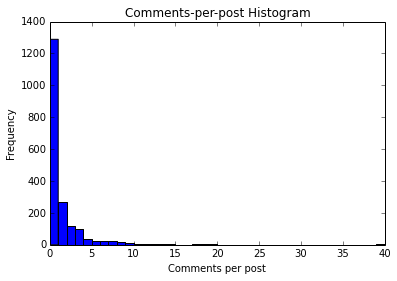

In [199]:
comments_threads = [data['comments'] for data in big_data if 'comments' in data]
count_of_posts_with_no_comments = len(big_data) - len(comments_threads)
comments_counts = [0] * count_of_posts_with_no_comments
comments_counts += [len(flatten_comments_pages(thread)) for thread in comments_threads]

import matplotlib.pyplot as plt
plt.hist(comments_counts, bins=max(comments_counts))
plt.title("Comments-per-post Histogram")
plt.xlabel("Comments per post")
plt.ylabel("Frequency")
plt.show()

This sort of adds up intuitively; posts with long comment threads will be rare, though from experience with this forum it does not seem right to conclude that there is a lot of posting going on with no interaction... the community is a bit more engaged than that. 

But since this is Facebook, comments aren't the only way of interacting with a post. There's also the wonderful 'Like'.

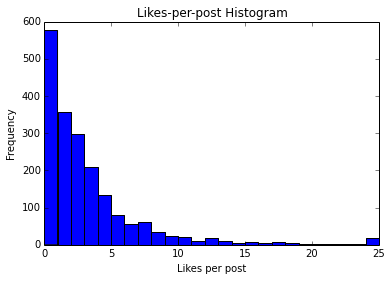

In [208]:
likes_threads = [data['likes']['data'] for data in big_data if 'likes' in data]
count_of_posts_with_no_likes = len(big_data) - len(likes_threads)
likes_counts = [0] * count_of_posts_with_no_likes
likes_counts += [len(thread) for thread in likes_threads]

import matplotlib.pyplot as plt
plt.hist(likes_counts, bins=max(likes_counts))
plt.title("Likes-per-post Histogram")
plt.xlabel("Likes per post")
plt.ylabel("Frequency")
plt.show()

Note that the above does not include Likes on Comments made on posts; only Likes made on posts themselves are counted.

While this paints the picture of a more engaged community, it still doesn't feel quite right. It feels like a rarity these days to find a post go by without a Like or two. 

TODO:
* Get a list of only posts with 0 Likes and try to find out what's up with them
* Pick out that post with 25 likes